# Statewide Bicycle Crash Analysis in North Carolina (2007-2018)

In [1]:
# Dependencies and Setup
#%matplotlib notebook
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from pprint import pprint

import requests
import json
import time
import gmaps
#from us import states
from config import gkey

In [2]:
# Read the csv file containing the Bicycle Crash data for North Carolina
input_file_path = "Resources/bicycle-crash-data-chapel-hill-region.csv"
crash_data = pd.read_csv(input_file_path, delimiter = ";")

# View the csv file containing the Bicycle Crash data for North Carolina
crash_data

# There are 11266 records in 55 columns

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdConditio,RdConfig,RdDefects,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone
0,"33.9437020597,-78.3493385901",Yes,70,70+,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No
1,"35.3217726,-79.0388423701",Yes,8,6-10,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,T-Intersection,Smooth Asphalt,Rural,50 - 55 MPH,Stop Sign,Clear,No
2,"35.77105009,-78.6073184803",Yes,13,11-15,No,No,Facing Traffic,A: Suspected Serious Injury,Travel Lane,Black,...,Dry,"Two-Way, Divided, Positive Median Barrier",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Cloudy,No
3,"35.9394515202,-77.7953706304",Yes,52,50-59,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Black,...,Dry,"One-Way, Not Divided",None,Four-Way Intersection,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
4,"36.0927628197,-80.2653764398",Yes,27,25-29,No,No,Not Applicable,C: Possible Injury,Non-Roadway,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11261,"34.2546581498,-77.9197554903",Yes,26,25-29,No,No,Facing Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
11262,"35.2123611203,-80.7913412696",Yes,20,20-24,No,No,Facing Traffic,C: Possible Injury,Sidewalk / Crosswalk / Driveway Crossing,Black,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,No Control Present,Cloudy,No
11263,"35.64331907,-80.4828223001",Yes,11,11-15,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Unknown/Missing,...,Dry,"Two-Way, Divided, Unprotected Median",None,No Special Feature,Smooth Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No
11264,"34.1935523204,-77.9356315301",No,60,60-69,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No


### Cleaning the Crash Group data

In [3]:
# Clear rows with missing data in any column
clean_crash_data = crash_data.dropna(how='any')
clean_crash_data
# None of the records were deleted so none of the rows have missing data

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdConditio,RdConfig,RdDefects,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone
0,"33.9437020597,-78.3493385901",Yes,70,70+,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No
1,"35.3217726,-79.0388423701",Yes,8,6-10,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,T-Intersection,Smooth Asphalt,Rural,50 - 55 MPH,Stop Sign,Clear,No
2,"35.77105009,-78.6073184803",Yes,13,11-15,No,No,Facing Traffic,A: Suspected Serious Injury,Travel Lane,Black,...,Dry,"Two-Way, Divided, Positive Median Barrier",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Cloudy,No
3,"35.9394515202,-77.7953706304",Yes,52,50-59,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Black,...,Dry,"One-Way, Not Divided",None,Four-Way Intersection,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
4,"36.0927628197,-80.2653764398",Yes,27,25-29,No,No,Not Applicable,C: Possible Injury,Non-Roadway,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11261,"34.2546581498,-77.9197554903",Yes,26,25-29,No,No,Facing Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
11262,"35.2123611203,-80.7913412696",Yes,20,20-24,No,No,Facing Traffic,C: Possible Injury,Sidewalk / Crosswalk / Driveway Crossing,Black,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,No Control Present,Cloudy,No
11263,"35.64331907,-80.4828223001",Yes,11,11-15,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Unknown/Missing,...,Dry,"Two-Way, Divided, Unprotected Median",None,No Special Feature,Smooth Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No
11264,"34.1935523204,-77.9356315301",No,60,60-69,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No


In [4]:
# Crashes by Crash Gpr
crashes_by_crashgrp = crash_data.groupby(["CrashGrp"])["geo_point_2d"].count()
crashes_by_crashgrp

# Needs cleaning

CrashGrp
Backing Vehicle                                               88
Bicyclist Failed to Yield - Midblock                         689
Bicyclist Failed to Yield - Sign-Controlled Intersection     642
Bicyclist Failed to Yield - Signalized Intersection          478
Bicyclist Failed to Yield—Midblock                            50
Bicyclist Failed to Yield—Sign-Controlled Intersection        37
Bicyclist Failed to Yield—Signalized Intersection             52
Bicyclist Left Turn / Merge                                  461
Bicyclist Left Turn/Merge                                     42
Bicyclist Overtaking Motorist                                232
Bicyclist Right Turn / Merge                                 128
Bicyclist Right Turn/Merge                                     6
Crossing Paths - Other Circumstances                         616
Crossing Paths—Other Circumstances                            58
Head-On                                                      300
Loss of Control 

In [5]:
# Cleaning Crash Group
crash_data["CrashGrp"] = crash_data["CrashGrp"].replace(
    {"Bicyclist Failed to Yield—Midblock": "Bicyclist Failed to Yield - Midblock",
    "Bicyclist Failed to Yield—Sign-Controlled Intersection": "Bicyclist Failed to Yield - Sign-Controlled Intersection",
    "Bicyclist Failed to Yield—Signalized Intersection": "Bicyclist Failed to Yield - Signalized Intersection",
    "Bicyclist Left Turn/Merge": "Bicyclist Left Turn / Merge",
    "Bicyclist Right Turn/Merge": "Bicyclist Right Turn / Merge",
    "Crossing Paths—Other Circumstances": "Crossing Paths - Other Circumstances",
    "Loss of Control/Turning Error": "Loss of Control / Turning Error",
    "Motorist Failed to Yield—Midblock": "Motorist Failed to Yield - Midblock",
    "Motorist Failed to Yield—Sign-Controlled Intersection": "Motorist Failed to Yield - Sign-Controlled Intersection",
    "Motorist Failed to Yield—Signalized Intersection": "Motorist Failed to Yield - Signalized Intersection",
    "Motorist Left Turn/Merge": "Motorist Left Turn / Merge",
     "Motorist Right Turn/Merge": "Motorist Right Turn / Merge",
     "Nonroadway": "Non-Roadway",
     "Other/Unknown—Insufficient Details": "Other / Unknown - Insufficient Details",
     "Other/Unusual Circumstances": "Other / Unusual Circumstances",
     "Parallel Paths—Other Circumstances": "Parallel Paths - Other Circumstances"
    })
crash_data["CrashGrp"]

0                                          Backing Vehicle
1                          Loss of Control / Turning Error
2        Bicyclist Failed to Yield - Signalized Interse...
3        Bicyclist Failed to Yield - Signalized Interse...
4                     Bicyclist Failed to Yield - Midblock
                               ...                        
11261                          Motorist Right Turn / Merge
11262                 Crossing Paths - Other Circumstances
11263                 Bicyclist Failed to Yield - Midblock
11264                        Motorist Overtaking Bicyclist
11265                        Motorist Overtaking Bicyclist
Name: CrashGrp, Length: 11266, dtype: object

In [6]:
# Check if all values were replaced correctly
# Crashes by Crash Gpr
crashes_by_crashgrp = crash_data.groupby(["CrashGrp"])["geo_point_2d"].count()
crashes_by_crashgrp.sort_values(ascending=False)

CrashGrp
Motorist Overtaking Bicyclist                               2207
Motorist Failed to Yield - Sign-Controlled Intersection     1073
Motorist Left Turn / Merge                                   978
Motorist Failed to Yield - Midblock                          824
Bicyclist Failed to Yield - Midblock                         739
Bicyclist Failed to Yield - Sign-Controlled Intersection     679
Crossing Paths - Other Circumstances                         674
Motorist Right Turn / Merge                                  585
Bicyclist Failed to Yield - Signalized Intersection          530
Non-Roadway                                                  503
Bicyclist Left Turn / Merge                                  503
Loss of Control / Turning Error                              477
Motorist Failed to Yield - Signalized Intersection           373
Head-On                                                      300
Bicyclist Overtaking Motorist                                232
Parallel Paths -

In [7]:
# Added 2 columns for latitude and longitude by splitting the "geo_point_2d" column for use in mapping
# Adding two new columns to the existing dataframe. 
# bydefault splitting is done on the basis of single space. 
crash_data[["Crash Latitude","Crash Longitude"]] = crash_data["geo_point_2d"].str.split(',',expand=True) 
crash_data

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdDefects,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude
0,"33.9437020597,-78.3493385901",Yes,70,70+,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,None,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No,33.9437020597,-78.3493385901
1,"35.3217726,-79.0388423701",Yes,8,6-10,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,None,T-Intersection,Smooth Asphalt,Rural,50 - 55 MPH,Stop Sign,Clear,No,35.3217726,-79.0388423701
2,"35.77105009,-78.6073184803",Yes,13,11-15,No,No,Facing Traffic,A: Suspected Serious Injury,Travel Lane,Black,...,None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Cloudy,No,35.77105009,-78.6073184803
3,"35.9394515202,-77.7953706304",Yes,52,50-59,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Black,...,None,Four-Way Intersection,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No,35.9394515202,-77.7953706304
4,"36.0927628197,-80.2653764398",Yes,27,25-29,No,No,Not Applicable,C: Possible Injury,Non-Roadway,White,...,None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No,36.0927628197,-80.2653764398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11261,"34.2546581498,-77.9197554903",Yes,26,25-29,No,No,Facing Traffic,C: Possible Injury,Travel Lane,White,...,None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No,34.2546581498,-77.9197554903
11262,"35.2123611203,-80.7913412696",Yes,20,20-24,No,No,Facing Traffic,C: Possible Injury,Sidewalk / Crosswalk / Driveway Crossing,Black,...,None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,No Control Present,Cloudy,No,35.2123611203,-80.7913412696
11263,"35.64331907,-80.4828223001",Yes,11,11-15,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Unknown/Missing,...,None,No Special Feature,Smooth Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No,35.64331907,-80.4828223001
11264,"34.1935523204,-77.9356315301",No,60,60-69,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,None,No Special Feature,Coarse Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No,34.1935523204,-77.9356315301


## Studying the crash data

In [8]:
# Number of cities included in the study
total_crash_count = crash_data["geo_point_2d"].count()
county_count = crash_data["County"].nunique()
city_count = crash_data["City"].nunique()


print(f"Total number of Bicycle Crashes in North Carolina (2007-2018) = {total_crash_count}")
print (f"Number of Counties included in the study: {county_count}")
print (f"Number of Cities included in the study: {city_count}")

Total number of Bicycle Crashes in North Carolina (2007-2018) = 11266
Number of Counties included in the study: 100
Number of Cities included in the study: 327


### Time Analysis

CrashYear
2007    1001
2008    1018
2009     811
2010     967
2011     899
2012    1020
2013     897
2014     850
2015     949
2016     955
2017    1000
2018     899
Name: geo_point_2d, dtype: int64
Total Crashes: 11266


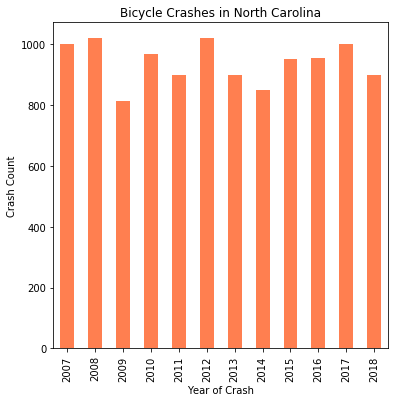

In [9]:
# Crash count grouped by Crash year
crashes_by_year = crash_data.groupby(["CrashYear"])["geo_point_2d"].count()
print(crashes_by_year)
print(f"Total Crashes: {total_crash_count}")

# Create a bar plot for crashes over time
fig, ax = plt.subplots()
ax = crashes_by_year.plot(kind='bar', figsize = (6,6), color = "coral")
ax.set_xlabel("Year of Crash")
ax.set_ylabel("Crash Count")
ax.set_title("Bicycle Crashes in North Carolina")

# Save the bar plot for crashes over time
plt.savefig("Output/CrashesOverTime.png")

# Display the bar plot for crashes over time
plt.show()

            Number of Crashes  Percent(%)
CrashMonth                               
September                1248       11.08
August                   1239       11.00
July                     1204       10.69
June                     1154       10.24
October                  1125        9.99
May                      1123        9.97
April                     975        8.65
November                  837        7.43
March                     742        6.59
December                  590        5.24
January                   516        4.58
February                  513        4.55
Total Crashes: 11266


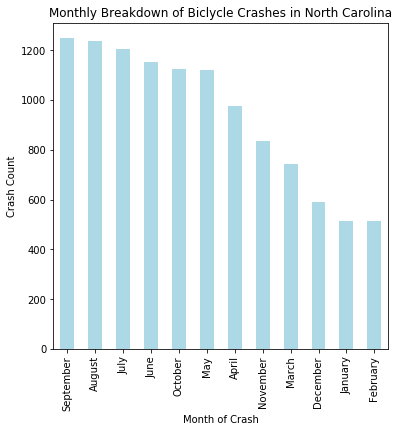

In [42]:
# Crash count grouped by Crash Month
crashes_by_month = crash_data.groupby(["CrashMonth"])["geo_point_2d"].count()
crashes_by_month = crashes_by_month.sort_values(ascending=False)

crashes_by_month_df = pd.DataFrame(crashes_by_month)
crashes_by_month_df.rename(columns = {"geo_point_2d": "Number of Crashes"}, inplace = True)

monthly_total = crashes_by_month_df["Number of Crashes"].sum()
crashes_by_month_df["Percent(%)"] = ""

for row in range(len(crashes_by_month_df)):
      crashes_by_month_df["Percent(%)"] = round((crashes_by_month_df["Number of Crashes"] / monthly_total)*100, 2) 

print(crashes_by_month_df)
print(f"Total Crashes: {monthly_total}")

# Create a bar plot for monthly breakdown of crashes 
fig, ax = plt.subplots()
ax = crashes_by_month.plot(kind='bar', figsize = (6,6), color = "lightblue", )

ax.set_xlabel("Month of Crash")
ax.set_ylabel("Crash Count")
ax.set_title("Monthly Breakdown of Biclycle Crashes in North Carolina")

# Save the bar plot for monthly breakdown of crashes
plt.savefig("Output/MonthlyBreakdown.png")

# Display the bar plot for monthly breakdown of crashes
plt.show()

In [55]:
# Crashes by Time of Day
# Create bins for Time of Day
time_bins = [0, 6, 12, 18, 20, 24]
time_group_names = ["Early Morning (12-6am)", "Morning (6am-12pm)", "Noon (12-4pm)", "Evening (4-8pm)", "Night (8pm-12am)"]

# Categorize crashes using time bins using pd.cut() and add new column for time of day
crash_data["Time of Day"] = pd.cut(crash_data["CrashHour"], time_bins, include_lowest = False, labels=time_group_names)
# test = crash_data[["CrashHour", "Time of Day"]]
# test

# Create a GroupBy object based on the time of Day - Crash count by time of Day
crashes_by_timeofday = crash_data.groupby("Time of Day")["geo_point_2d"].count()
# print(crash_count_by_time_of_day)

crashes_by_timeofday_df = pd.DataFrame(crashes_by_timeofday)
crashes_by_timeofday_df.rename(columns = {"geo_point_2d": "Number of Crashes"}, inplace = True)
crashes_by_timeofday_df["Percent(%)"] = ""

for row in range(len(crashes_by_timeofday_df)):
      crashes_by_timeofday_df["Percent(%)"] = round((crashes_by_timeofday_df["Number of Crashes"] / total_crash_count)*100, 2) 

crashes_by_timeofday_df#.sort_values(by="Number of Crashes", ascending=False)
            

,Number of Crashes,Percent(%)
Time of Day,,
Early Morning (12-6am),533,4.73
Morning (6am-12pm),2776,24.64
Noon (12-4pm),5538,49.16
Evening (4-8pm),1391,12.35
Night (8pm-12am),917,8.14


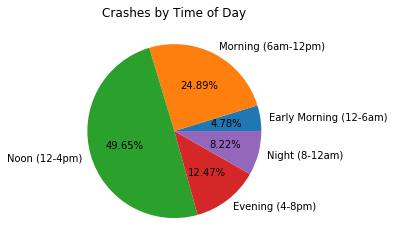

In [53]:
# Create a pie plot for crashes by Time of Day
fig, ax1 = plt.subplots()
#pie_colors = ("peachpuff", "coral", "tan", "gold", "wheat", "goldenrod", "khaki")
ax1 = crashes_by_timeofday_df["Number of Crashes"].plot(kind='pie', autopct = "%.2f%%", figsize = (40,40), subplots=True)
plt.title("Crashes by Time of Day")
plt.axis("off") # remove the axis labels
# Save the pie plot for crashes by Time of Day
plt.savefig("Output/TimeofDayAnalysis.png")

# Display the bar plot for crashes by Time of Day
plt.show()

In [12]:
# Nighttime bicycle crashes resulted in more fatalities compared to daytime crashes.
fatality_by_timeofday = crash_data[["geo_point_2d", "CrashSevr", "Time of Day"]]
fatality_by_timeofday

,geo_point_2d,CrashSevr,Time of Day
0,"33.9437020597,-78.3493385901",C: Possible Injury,Morning (12am-12pm)
1,"35.3217726,-79.0388423701",C: Possible Injury,Evening (3pm-8pm)
2,"35.77105009,-78.6073184803",A: Suspected Serious Injury,Noon (12pm-3pm)
3,"35.9394515202,-77.7953706304",C: Possible Injury,Morning (12am-12pm)
4,"36.0927628197,-80.2653764398",C: Possible Injury,Noon (12pm-3pm)
...,...,...,...
11261,"34.2546581498,-77.9197554903",C: Possible Injury,Morning (12am-12pm)
11262,"35.2123611203,-80.7913412696",C: Possible Injury,Evening (3pm-8pm)
11263,"35.64331907,-80.4828223001",C: Possible Injury,Evening (3pm-8pm)
11264,"34.1935523204,-77.9356315301",C: Possible Injury,Night (8pm-12am)


Total Crashes: 11266
                                                    Number of Crashes  \
CrashType                                                               
Motorist Overtaking - Other / Unknown                            1170   
Motorist Drive Out - Sign-Controlled Intersection                 991   
Motorist Left Turn - Opposite Direction                           850   
Motorist Drive Out - Commercial Driveway / Alley                  677   
Bicyclist Ride Through - Sign-Controlled Inters...                545   

                                                    Percent(%)  
CrashType                                                       
Motorist Overtaking - Other / Unknown                    10.39  
Motorist Drive Out - Sign-Controlled Intersection         8.80  
Motorist Left Turn - Opposite Direction                   7.54  
Motorist Drive Out - Commercial Driveway / Alley          6.01  
Bicyclist Ride Through - Sign-Controlled Inters...        4.84  


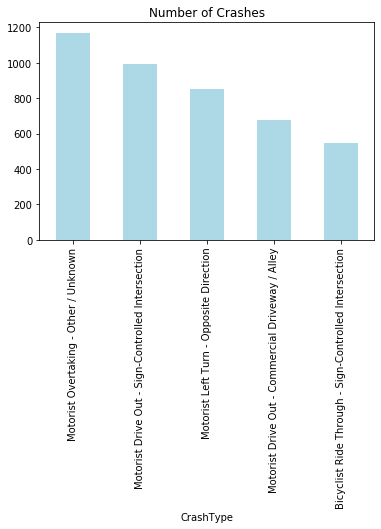

In [13]:
# Crash count by Crash Type
# Crash count grouped by Crash Type
crashes_by_crashtype = crash_data.groupby(["CrashType"])["geo_point_2d"].count()
crashes_by_crashtype = crashes_by_crashtype.sort_values(ascending=False)

crashes_by_crashtype_df = pd.DataFrame(crashes_by_crashtype)
crashes_by_crashtype_df.rename(columns = {"geo_point_2d": "Number of Crashes"}, inplace = True)

crashes_by_crashtype_df["Percent(%)"] = ""
for row in range(len(crashes_by_crashtype_df)):
      crashes_by_crashtype_df["Percent(%)"] = round((crashes_by_crashtype_df["Number of Crashes"] / total_crash_count)*100, 2) 

# print(crashes_by_crashtype_df)
print(f"Total Crashes: {total_crash_count}")

top5_crashtypes = crashes_by_crashtype_df.sort_values(by="Number of Crashes",ascending=False).head()
top5_crashtypes_df = pd.DataFrame(top5_crashtypes)
print(top5_crashtypes_df)

# Create a bar plot for crashes by Crash Type 
fig, ax = plt.subplots()
ax = top5_crashtypes_df["Number of Crashes"].plot(kind='bar', figsize = (6,6), color = "lightblue", subplots=True)
# ax.set_xlabel("Tpo 5 Types of Crashes")
# ax.set_ylabel("Crash Count")
# ax.set_title("Crash Type Analysis- Top 5")

# Save the bar plot for crashes by Crash Type
plt.savefig("Output/CrashTypeAnalysis.png")

# Display the bar plot for crashes by Crash Type
plt.show()

                 Number of Crashes  Percent(%)
BikeRace                                      
White                         6178       54.84
Black                         3847       34.15
Hispanic                       603        5.35
Unknown/Missing                265        2.35
Other                          133        1.18
Native American                130        1.15
Asian                          110        0.98
Total Crashes: 11266


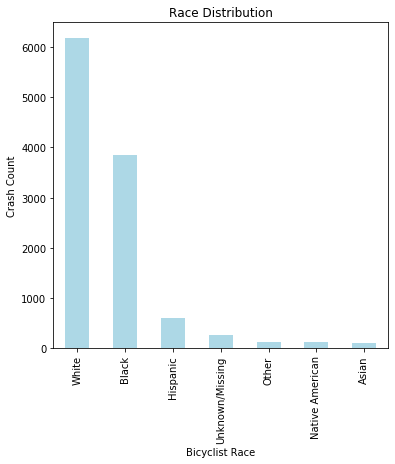

In [14]:
# Crash count grouped by Bikers Race
crashes_by_bikers_race = crash_data.groupby(["BikeRace"])["geo_point_2d"].count()
crashes_by_bikers_race = crashes_by_bikers_race.sort_values(ascending=False)

crashes_by_bikers_race_df = pd.DataFrame(crashes_by_bikers_race)
crashes_by_bikers_race_df.rename(columns = {"geo_point_2d": "Number of Crashes"}, inplace = True)

crashes_by_bikers_race_df["Percent(%)"] = ""
for row in range(len(crashes_by_month_df)):
      crashes_by_bikers_race_df["Percent(%)"] = round((crashes_by_bikers_race_df["Number of Crashes"] / total_crash_count)*100, 2) 
print(crashes_by_bikers_race_df)
print(f"Total Crashes: {total_crash_count}")

# Create a bar plot for crashes by Bikers Race 
fig, ax = plt.subplots()
ax = crashes_by_bikers_race.plot(kind='bar', figsize = (6,6), color = "lightblue", )
ax.set_xlabel("Bicyclist Race")
ax.set_ylabel("Crash Count")
ax.set_title("Race Distribution")

# Save the bar plot for crashes by Bikers Race
plt.savefig("Output/RaceDistribution.png")

# Display the bar plot for crashes by Bikers Race
plt.show()


                 Number of Crashes  Percent(%)
BikeRace                                      
White                         6178       54.84
Black                         3847       34.15
Hispanic                       603        5.35
Unknown/Missing                265        2.35
Other                          133        1.18
Native American                130        1.15
Asian                          110        0.98


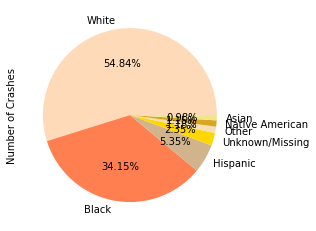

In [15]:
# Create a pie plot for crashes by Bicyclist's Race
fig, ax1 = plt.subplots()
pie_colors = ("peachpuff", "coral", "tan", "gold", "wheat", "goldenrod", "khaki")
ax1 = crashes_by_bikers_race_df["Number of Crashes"].plot(kind='pie', autopct = "%.2f%%", figsize = (40,40), colors = pie_colors, subplots=True)
# ax.set_xlabel("")
# ax.set_ylabel("")
# ax.set_title("Bicyclist's Race Analysis")
print(crashes_by_bikers_race_df)
# Save the bar plot for crashes Bicyclist's Race
plt.savefig("Output/BicyclistRaceDistribution.png")

# Display the bar plot for crashes Bicyclist's Race
plt.show()

             Number of Crashes  Percent(%)
County                                    
Wake                      1500       13.31
Mecklenburg               1421       12.61
New Hanover                767        6.81
Guilford                   741        6.58
Durham                     539        4.78
Total Crashes: 11266


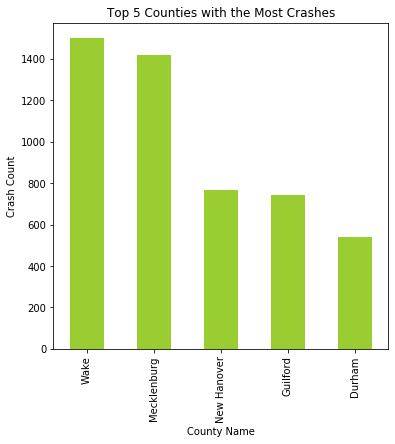

In [16]:
# Crash count grouped by County
crashes_by_county = crash_data.groupby(["County"])["geo_point_2d"].count()
crashes_by_county_df = pd.DataFrame(crashes_by_county)
crashes_by_county_df.rename(columns = {"geo_point_2d": "Number of Crashes"}, inplace = True)

crashes_by_county_df["Percent(%)"] = ""

for row in range(len(crashes_by_county_df)):
      crashes_by_county_df["Percent(%)"] = round((crashes_by_county_df["Number of Crashes"] / total_crash_count)*100, 2) 

top5_counties = crashes_by_county_df.sort_values(["Number of Crashes"], ascending=False).head()
top5_counties_df = pd.DataFrame(top5_counties)
print(top5_counties_df)
print(f"Total Crashes: {total_crash_count}")

# Create a bar plot for crashes by county 
fig, ax = plt.subplots()
ax = top5_counties["Number of Crashes"].plot(kind='bar', figsize = (6,6), color = "yellowgreen", )
ax.set_xlabel("County Name")
ax.set_ylabel("Crash Count")
ax.set_title("Top 5 Counties with the Most Crashes")

# Save the bar plot for crashes by county
plt.savefig("Output/Top5Counties.png")

# Display the bar plot for crashes by Bikers Race
plt.show()

                    Number of Crashes  Percent(%)
City                                             
None - Rural Crash               2404       21.34
Charlotte                        1284       11.40
Raleigh                          1025        9.10
Wilmington                        578        5.13
Durham                            500        4.44
Greensboro                        473        4.20
Total Crashes: 11266


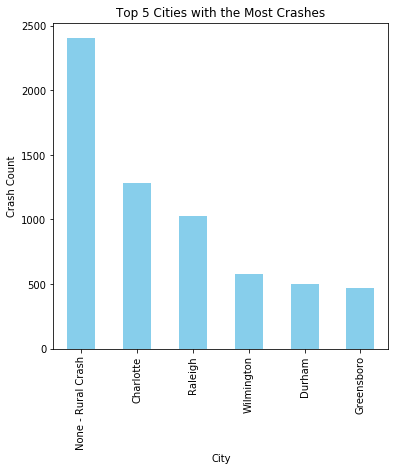

In [17]:
# Crash count grouped by City
crashes_by_city = crash_data.groupby(["City"])["geo_point_2d"].count()
crashes_by_city = crashes_by_city.sort_values(ascending=False)

top5_cities = crashes_by_city.head(6)
top5_cities_df = pd.DataFrame(top5_cities)
top5_cities_df.rename(columns = {"geo_point_2d": "Number of Crashes"}, inplace = True)

top5_cities_df["Percent(%)"] = ""
for row in range(len(top5_cities_df)):
      top5_cities_df["Percent(%)"] = round((top5_cities_df["Number of Crashes"] / total_crash_count)*100, 2) 

print(top5_cities_df)
print(f"Total Crashes: {total_crash_count}")

# Create a bar plot for crashes by City 
fig, ax = plt.subplots()
ax = top5_cities.plot(kind='bar', figsize = (6,6), color = "skyblue", )
ax.set_xlabel("City")
ax.set_ylabel("Crash Count")
ax.set_title("Top 5 Cities with the Most Crashes")

# Save the bar plot for crashes by City
plt.savefig("Output/Top5Cities.png")

# Display the bar plot for crashes by City
plt.show()

         Number of Crashes  Percent(%)
BikeSex                               
Male                  9391       83.36
Female                1669       14.81
Unknown                206        1.83
Total Crashes: 11266


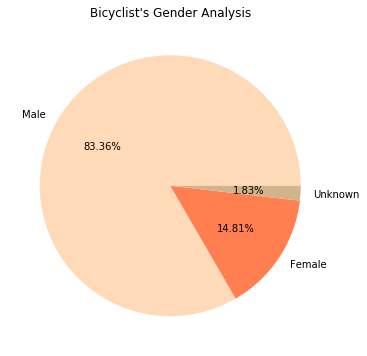

In [18]:
# Crashes by Bicyclist's Gender
crashes_by_gender = crash_data.groupby(["BikeSex"])["geo_point_2d"].count()
crashes_by_gender = crashes_by_gender.sort_values(ascending=False)

crashes_by_gender_df = pd.DataFrame(crashes_by_gender)
crashes_by_gender_df.rename(columns = {"geo_point_2d": "Number of Crashes"}, inplace = True)
crashes_by_gender_df["Percent(%)"] = ""
for row in range(len(crashes_by_gender_df)):
      crashes_by_gender_df["Percent(%)"] = round((crashes_by_gender_df["Number of Crashes"] / total_crash_count)*100, 2) 

print(crashes_by_gender_df)
print(f"Total Crashes: {total_crash_count}")

# Create a pie plot for crashes by Bicyclist's Gender
fig, ax = plt.subplots()
pie_colors = ("peachpuff", "coral", "tan")
ax = crashes_by_gender.plot(kind='pie', autopct = "%.2f%%", figsize = (6,6), colors = pie_colors)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Bicyclist's Gender Analysis")

# Save the bar plot for crashes Bicyclist's Gender
plt.savefig("Output/BicyclistGenderDistribution.png")

# Display the bar plot for crashes Bicyclist's Gender
plt.show()

                                             Number of Crashes  Percent(%)
BikeAlcDrg                                                                
No                                                        7493       66.51
.                                                         2830       25.12
Yes-Alcohol, impairment suspected                          357        3.17
Missing                                                    253        2.25
Unknown                                                    233        2.07
Yes-Alcohol, impairment detected                            57        0.51
Yes-Alcohol and Drugs, impairment suspected                 20        0.18
Yes-Drugs, impairment suspected                             15        0.13
Yes-Alcohol and Drugs, impairment detected                   6        0.05
Yes-Drugs, impairment detected                               2        0.02
Total Crashes: 11266


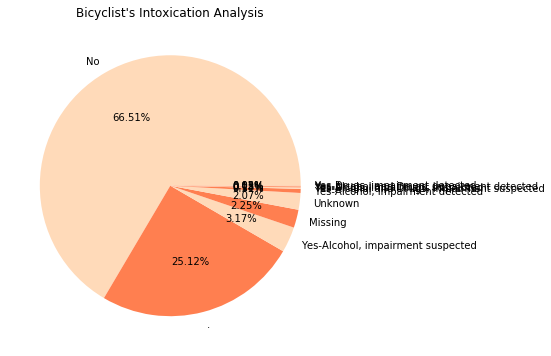

In [19]:
# Crashes where bikers were intoxicated either by alcohol or drugs
crashes_by_biker_intox = crash_data.groupby(["BikeAlcDrg"])["geo_point_2d"].count()
crashes_by_biker_intox = crashes_by_biker_intox.sort_values(ascending=False)

crashes_by_biker_intox_df = pd.DataFrame(crashes_by_biker_intox)
crashes_by_biker_intox_df.rename(columns = {"geo_point_2d": "Number of Crashes"}, inplace = True)
crashes_by_biker_intox_df["Percent(%)"] = ""
for row in range(len(crashes_by_biker_intox_df)):
      crashes_by_biker_intox_df["Percent(%)"] = round((crashes_by_biker_intox_df["Number of Crashes"] / total_crash_count)*100, 2) 

print(crashes_by_biker_intox_df)
print(f"Total Crashes: {total_crash_count}")

# Create a pie plot for Crashes where bikers were intoxicated
fig, ax = plt.subplots()
pie_colors = ("peachpuff", "coral")
ax = crashes_by_biker_intox.plot(kind='pie', autopct = "%.2f%%", figsize = (6,6), colors = pie_colors)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Bicyclist's Intoxication Analysis")

# Save the bar plot for Crashes where bikers were intoxicated
plt.savefig("Output/BicyclistIntoxication.png")

# Display the bar plot for Crashes where bikers were intoxicated
plt.show()

In [20]:
# 

                                             Number of Crashes  Percent(%)
DrvrAlcDrg                                                                
No                                                        7001       62.14
.                                                         2830       25.12
Missing                                                    945        8.39
Unknown                                                    353        3.13
Yes-Alcohol, impairment suspected                           76        0.67
Yes-Alcohol, impairment detected                            31        0.28
Yes-Drugs, impairment suspected                             14        0.12
Yes-Alcohol and Drugs, impairment suspected                 10        0.09
Yes-Drugs, impairment detected                               5        0.04
Yes-Alcohol and Drugs, impairment detected                   1        0.01


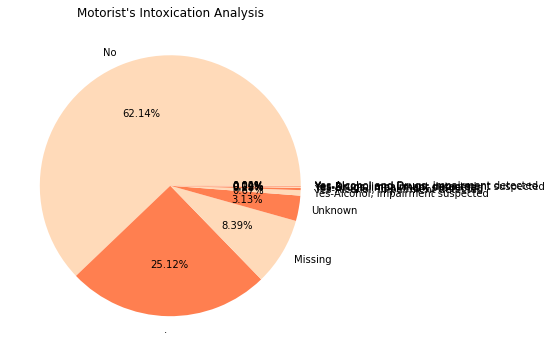

In [21]:
# Crashes where motorist were intoxicated
crashes_by_motorist_intox = crash_data.groupby(["DrvrAlcDrg"])["geo_point_2d"].count()
crashes_by_motorist_intox = crashes_by_motorist_intox.sort_values(ascending=False)

crashes_by_motorist_intox_df = pd.DataFrame(crashes_by_motorist_intox)
crashes_by_motorist_intox_df.rename(columns = {"geo_point_2d": "Number of Crashes"}, inplace = True)
crashes_by_motorist_intox_df["Percent(%)"] = ""
for row in range(len(crashes_by_motorist_intox_df)):
      crashes_by_motorist_intox_df["Percent(%)"] = round((crashes_by_motorist_intox_df["Number of Crashes"] / total_crash_count)*100, 2) 

print(crashes_by_motorist_intox_df)

# Create a pie plot for Crashes where motorists were intoxicated
fig, ax = plt.subplots()
pie_colors = ("peachpuff", "coral")
ax = crashes_by_motorist_intox.plot(kind='pie', autopct = "%.2f%%", figsize = (6,6), colors = pie_colors)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Motorist's Intoxication Analysis")

# Save the bar plot for Crashes where bikers were intoxicated
plt.savefig("Output/MotoristIntoxication.png")

# Display the bar plot for Crashes where bikers were intoxicated
plt.show()

In [25]:
# Crashes by Locality
crashes_by_locality = crash_data.groupby(["Locality"])["geo_point_2d"].count()
crashes_by_locality

Locality
Mixed (30% To 70% Developed)    1568
Rural (<30% Developed)          1658
Urban (>70% Developed)          8040
Name: geo_point_2d, dtype: int64

In [26]:
# Crashes by Day of Week
crashes_by_weekday = crash_data.groupby(["Day of Week"])["geo_point_2d"].count()
crashes_by_weekday.sort_values(ascending=False)

Day of Week
Friday       1770
Thursday     1701
Wednesday    1697
Tuesday      1695
Monday       1624
Saturday     1503
Sunday       1276
Name: geo_point_2d, dtype: int64

In [62]:
# Crashes by Hit or Run
#killed = crash_data.loc[crash_data["BikeInjury"] == "K: Killed",:]

hitrun_killed = crash_data.groupby(["HitRun", "DrvrInjury"])["geo_point_2d"].count()
hitrun_killed

# # Create a pie plot for Hit n Run
# fig, ax = plt.subplots()
# ax = hitrun_killed.plot(kind='pie', autopct = "%.2f%%", figsize = (6,6))
# ax.set_xlabel("")
# ax.set_ylabel("")
# ax.set_title("Fatal Hit and Run crashes")

# # Save the bar plot for crashes over time
# plt.savefig("Output/HitnRunKilled.png")

# # Display the bar plot for crashes over time
# plt.show()


HitRun  DrvrInjury                 
No      A: Suspected Serious Injury       9
        B: Suspected Minor Injury        81
        C: Possible Injury              163
        K: Killed                         2
        O: No Injury                   9163
        Unknown Injury                  187
Yes     A: Suspected Serious Injury       1
        B: Suspected Minor Injury         1
        C: Possible Injury                5
        O: No Injury                    227
        Unknown Injury                 1427
Name: geo_point_2d, dtype: int64

In [28]:
# Gender Vs. Severity

#gender_study = crash_data[["geo_point_2d", "BikeSex", "CrashSevr", "BikeInjury", "BikeDir"]]
gender_study = crash_data.loc[crash_data["BikeInjury"] == "K: Killed",:]

gender_severity = gender_study.groupby(["BikeSex"])["geo_point_2d"].count()
gender_severity_df = pd.DataFrame(gender_severity)


gender_severity_df.rename(columns = {"geo_point_2d": "Number of Crashes"}, inplace = True)
gender_severity_df["Percent(%)"] = ""
for row in range(len(gender_severity_df)):
      gender_severity_df["Percent(%)"] = round((gender_severity_df["Number of Crashes"] / total_crash_count)*100, 2) 

gender_study

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude,Time of Day,Biker Intoxicated,Motorist Intoxicated
51,"35.2467159998,-81.4257199999",Yes,46,40-49,.,No,With Traffic,K: Killed,Bike Lane / Paved Shoulder,White,...,Rural,60 - 75 MPH,No Control Present,Clear,No,35.2467159998,-81.4257199999,Morning (12am-12pm),No,No
71,"36.294113,-78.5467199997",Yes,45,40-49,.,No,With Traffic,K: Killed,Travel Lane,Black,...,Rural,20 - 25 MPH,No Control Present,Rain,No,36.294113,-78.5467199997,Night (8pm-12am),No,No
128,"34.1079300003,-77.9219800001",Yes,45,40-49,.,No,With Traffic,K: Killed,Bike Lane / Paved Shoulder,White,...,Rural,50 - 55 MPH,Other,Clear,No,34.1079300003,-77.9219800001,Evening (3pm-8pm),No,No
153,"35.7214929998,-78.8649700004",Yes,51,50-59,.,No,With Traffic,K: Killed,Travel Lane,White,...,Urban,40 - 45 MPH,No Control Present,Clear,No,35.7214929998,-78.8649700004,Morning (12am-12pm),No,No
183,"36.2290972498,-79.2963211904",Yes,54,50-59,"Yes-Alcohol, impairment detected",Yes,With Traffic,K: Killed,Travel Lane,Black,...,Rural,50 - 55 MPH,No Control Present,"Fog, Smog, Smoke",No,36.2290972498,-79.2963211904,Night (8pm-12am),No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11088,"35.8762974499,-78.5397780605",Yes,49,40-49,No,No,With Traffic,K: Killed,Travel Lane,White,...,Urban,50 - 55 MPH,No Control Present,Clear,No,35.8762974499,-78.5397780605,Noon (12pm-3pm),No,No
11125,"36.4367982501,-77.8760720501",Yes,58,50-59,"Yes-Alcohol, impairment suspected",Yes,Unknown,K: Killed,Travel Lane,Black,...,Rural,50 - 55 MPH,"Double Yellow Line, No Passing Zone",Cloudy,No,36.4367982501,-77.8760720501,Night (8pm-12am),No,No
11249,"36.4202171301,-77.1077045204",Yes,21,20-24,"Yes-Alcohol, impairment suspected",Yes,With Traffic,K: Killed,Travel Lane,Black,...,Rural,40 - 45 MPH,"Double Yellow Line, No Passing Zone",Clear,No,36.4202171301,-77.1077045204,Night (8pm-12am),No,No
11254,"34.9021944702,-79.0741062998",Yes,54,50-59,"Yes-Alcohol, impairment suspected",Yes,With Traffic,K: Killed,Travel Lane,White,...,Rural,50 - 55 MPH,"Double Yellow Line, No Passing Zone",Clear,No,34.9021944702,-79.0741062998,Night (8pm-12am),No,No


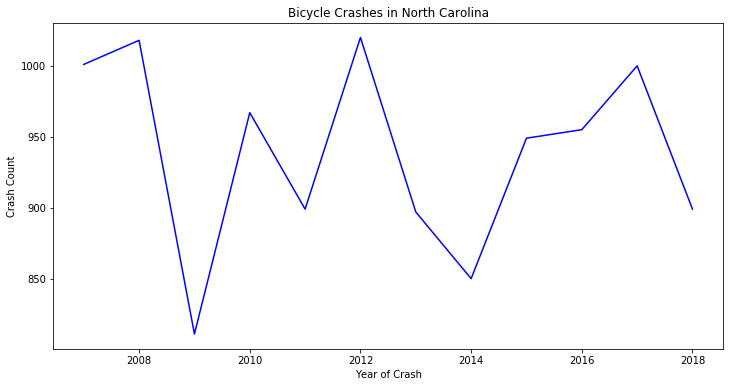

In [29]:
# Create a trendline for crashes over time
# Generate the bar plot for crashes over time
fig, ax = plt.subplots()
ax = crashes_by_year.plot(kind='line', figsize = (12,6), color = "blue")
ax.set_xlabel("Year of Crash")
ax.set_ylabel("Crash Count")
ax.set_title("Bicycle Crashes in North Carolina")

# Save the bar plot for crashes over time
plt.savefig("Output/YoYCrashTrend.png")

# Display the bar plot for crashes over time
plt.show()

In [30]:
# Sort by County, City
sorted_by_city = crash_data.groupby(["County", "City"])["geo_point_2d"].count()
sorted_by_city_df = pd.DataFrame(sorted_by_city)


sorted_by_city_df.rename(columns = {"geo_point_2d": "Number of Crashes"}, inplace = True)
sorted_by_city_df["Percent(%)"] = ""
for row in range(len(sorted_by_city_df)):
      sorted_by_city_df["Percent(%)"] = round((sorted_by_city_df["Number of Crashes"] / total_crash_count)*100, 2) 

sorted_by_city_df

Visualize at teh County --> City --> Crash Site

# 1. Create a dataframe with columns geopoint,county,city, Severity
# 2. Drop any null values/unknown values
# 3. Groupby County,City to find crash counts
# 4. Retrieve geojson at teh city level 
 

Use geoplaces to get the lat,long of each city
# 5. Pass those values and crash count to heatmaps
# Add city with max no.of crashes for each county.

SyntaxError: invalid syntax (<ipython-input-30-1ab4ca4434d9>, line 13)

# # Bicyclist Age Analysis

In [ ]:
# Identify the count of unique age group values
agegroup_unique_values = crash_data["BikeAgeGrp"].unique()
agegroup_unique_values

In [ ]:
# Identify all the values for age
age_unique_values = crash_data["BikeAge"].unique()
age_unique_values

In [ ]:
# Fine number of crashes by age group
crashes_by_age = crash_data.groupby(["BikeAgeGrp"])["geo_point_2d"].count()
crashes_by_age.sort_values(ascending=False)

# # Severity Analysis

In [ ]:
# Severity 
severity = crash_data.groupby(["County", "City", "CrashSevr"])["geo_point_2d"].count()
severity_df = pd.DataFrame(severity)
severity_df.rename(columns = {"geo_point_2d": "Number of Crashes"}, inplace = True)
severity_df["Percent (%)"] = ""

for row in range(len(severity_df)):
      severity_df["Percent (%)"] = round((severity_df["Number of Crashes"] / total_crash_count)*100, 2) 

severity_df.sort_values("Percent (%)", ascending=False)

In [ ]:
from pprint import pprint

# Configure gmaps with API key
gmaps.configure(api_key=gkey)

crash_hotspots = crash_data.groupby(["City"]).agg({"City":"count"})
crash_hotspots.columns=["Crash Count"]
crash_hotspots.reset_index(inplace=True)

crash_hotspots["City Latitude"] = ""
crash_hotspots["City Longitude"] = ""

params = {"key": gkey}

for index, row in crash_hotspots.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    current_city = row["City"]
    state = "North Carolina"
    params["address"] = f"{current_city},{state}"
    jsonresponse = requests.get(base_url, params=params).json()
    #pprint(jsonresponse,indent =4)
    current_city_latitude = jsonresponse["results"][0]["geometry"]["location"]["lat"]
    current_city_longitude = jsonresponse["results"][0]["geometry"]["location"]["lng"]
    crash_hotspots.loc[index,"City Latitude"] = current_city_latitude
    crash_hotspots.loc[index,"City Longitude"] = current_city_longitude
    
crash_hotspots.head(60)

In [ ]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

locations = crash_hotspots[["City Latitude", "City Longitude"]].astype(float)
crash_count = crash_hotspots["Crash Count"].astype(float)

# Create a Crash Count Heatmap layer for each city
fig1 = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=crash_count, 
                                 dissipating=False, max_intensity=1000,
                                 point_radius = 0.10)
fig1.add_layer(heat_layer)
fig

In [ ]:
crash_rate = crash_hotspots["Crash Count"].tolist()

# Create bank symbol layer
crash_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    info_box_content=[f"{City}" for City in crash_rate]
)
fig2 = gmaps.figure()
fig2.add_layer(crash_layer)

# Create a combined map
fig3 = gmaps.figure()
fig3.add_layer(heat_layer)
fig3.add_layer(crash_layer)
fig3

In [31]:
killed = crash_data.loc[crash_data["CrashSevr"] == "K: Killed",:]
fatal_cities = killed.groupby("City")["geo_point_2d"].count()

#fatality_hotspots_by_county = killed.groupby("County")["geo_point_2d"].count()


fatal_cities_df = pd.DataFrame(fatal_cities)
fatal_cities_df.rename(columns={"geo_point_2d": "Fatal Crash Count"}, inplace = True)
fatal_cities_df = fatal_cities_df.sort_values(by=["Fatal Crash Count"], ascending=False)
fatal_cities_df.reset_index(inplace=True)


fatal_cities_df["City Latitude"] = ""
fatal_cities_df["City Longitude"] = ""

params = {"key": gkey}

for index, row in fatal_cities_df.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    current_city = row["City"]
    state = "North Carolina"
    params["address"] = f"{current_city},{state}"
    jsonresponse = requests.get(base_url, params=params).json()
    #pprint(jsonresponse,indent =4)
    current_city_latitude = jsonresponse["results"][0]["geometry"]["location"]["lat"]
    current_city_longitude = jsonresponse["results"][0]["geometry"]["location"]["lng"]
    fatal_cities_df.loc[index,"City Latitude"] = current_city_latitude
    fatal_cities_df.loc[index,"City Longitude"] = current_city_longitude
    
fatal_cities_df = fatal_cities_df.drop([0])
fatal_cities_df

,City,Fatal Crash Count,City Latitude,City Longitude
1,Charlotte,20,35.2271,-80.8431
2,Raleigh,11,35.7796,-78.6382
3,Wilmington,10,34.2104,-77.8868
4,Durham,6,35.994,-78.8986
5,Lumberton,5,34.6182,-79.0086
6,Fayetteville,4,35.0527,-78.8784
7,Jacksonville,4,34.7541,-77.4302
8,Greensboro,3,36.0726,-79.792
9,Asheville,3,35.5951,-82.5515
10,High Point,2,35.9557,-80.0053


In [32]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

locations = fatal_cities_df[["City Latitude", "City Longitude"]].astype(float)
fatal_crash_count = fatal_cities_df["Fatal Crash Count"].astype(float)

# Create a Crash Count Heatmap layer for each city
fig = gmaps.figure()
fatal_heat_layer = gmaps.heatmap_layer(locations, weights=fatal_crash_count, 
                                 dissipating=False, max_intensity=5,
                                 point_radius = 0.10)
fig.add_layer(fatal_heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [33]:
fatal_crash_rate = fatal_cities_df["Fatal Crash Count"].tolist()

# Create bank symbol layer
fatal_crash_layer = gmaps.symbol_layer(locations, scale = 1)
fig = gmaps.figure()
fig.add_layer(fatal_crash_layer)

In [35]:
# Create a combined map
fig = gmaps.figure()
fig.add_layer(fatal_heat_layer)
fig.add_layer(fatal_crash_layer)
fig


Figure(layout=FigureLayout(height='420px'))

In [40]:
crashes = crash_data[["geo_point_2d", "County", "City"]]
crashes_df = crashes.groupby(["County"])["geo_point_2d"].count()
crashes_df.sort_values(ascending=False)


County
Wake           1500
Mecklenburg    1421
New Hanover     767
Guilford        741
Durham          539
               ... 
Tyrrell           3
Clay              3
Alexander         3
Mitchell          2
Alleghany         1
Name: geo_point_2d, Length: 100, dtype: int64